# Analysis of WaterLevels in Arnhem

The waterlevels in Arnhem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily

In [2]:
from common import RWSData, correlation_significance

In [3]:
plt.rcParams['figure.figsize'] = (20, 6)

# Getting data

In [4]:
start = datetime(2024, 1, 1, 0)
end   = datetime(2025, 1, 1, 0)
start, end

(datetime.datetime(2024, 1, 1, 0, 0), datetime.datetime(2025, 1, 1, 0, 0))

## Water level data

We get data for the last three months, for this we use the previously defined class `RWSData`.
And select the measured value (in dutch).

In [5]:
wl_df = RWSData().data_loc_datetime(start, end)[0][1]

In [6]:
raw_series = wl_df['Meetwaarde.Waarde_Numeriek']
raw_series.name = 'WaterLevel'
raw_series.reset_index().describe()

,Tijdstip,WaterLevel
count,31369,31369.000000
mean,2024-04-21 03:40:35.882559232,895.299244
min,2024-01-01 01:00:00,798.000000
25%,2024-02-25 03:30:00,833.000000
50%,2024-04-21 04:40:00,864.000000
75%,2024-06-16 01:20:00,933.000000
max,2024-08-10 08:10:00,1188.000000
std,NaN,81.140351


### Filtering

First we check how the the signal is distributed over time.
If the signal is equidistant in time then we can use filters such as moving average or FFT, otherwise not.
The signal is equidistant if all samples have the same interval, this is not the case with our data.

In [7]:
np.diff(wl_df.index).astype(float).std()

np.float64(233625644726.373)

### Momentary samples

First we try the simplest method to remove noise.

We select every zeroth minute for the hourly data, or every 8th hour for the daily data.
We use the 8th hour because that is what is historically (since the 1800's) the reference time for measurements in Arnhem.

We see that the time is still not equidistant, also the daily data misses some important peaks.

In [8]:
hourly_series = raw_series.loc[raw_series.index.minute == 0]
daily_series = raw_series.loc[(raw_series.index.hour == 8) & (wl_df.index.minute == 0)]

In [9]:
pd.Series({
    'Hourly': np.diff(hourly_series.index).astype(float).std(),
    'Daily': np.diff(daily_series.index).astype(float).std()
})

Hourly    1.539788e+12
Daily     1.419859e+13
dtype: float64

<Axes: xlabel='Tijdstip'>

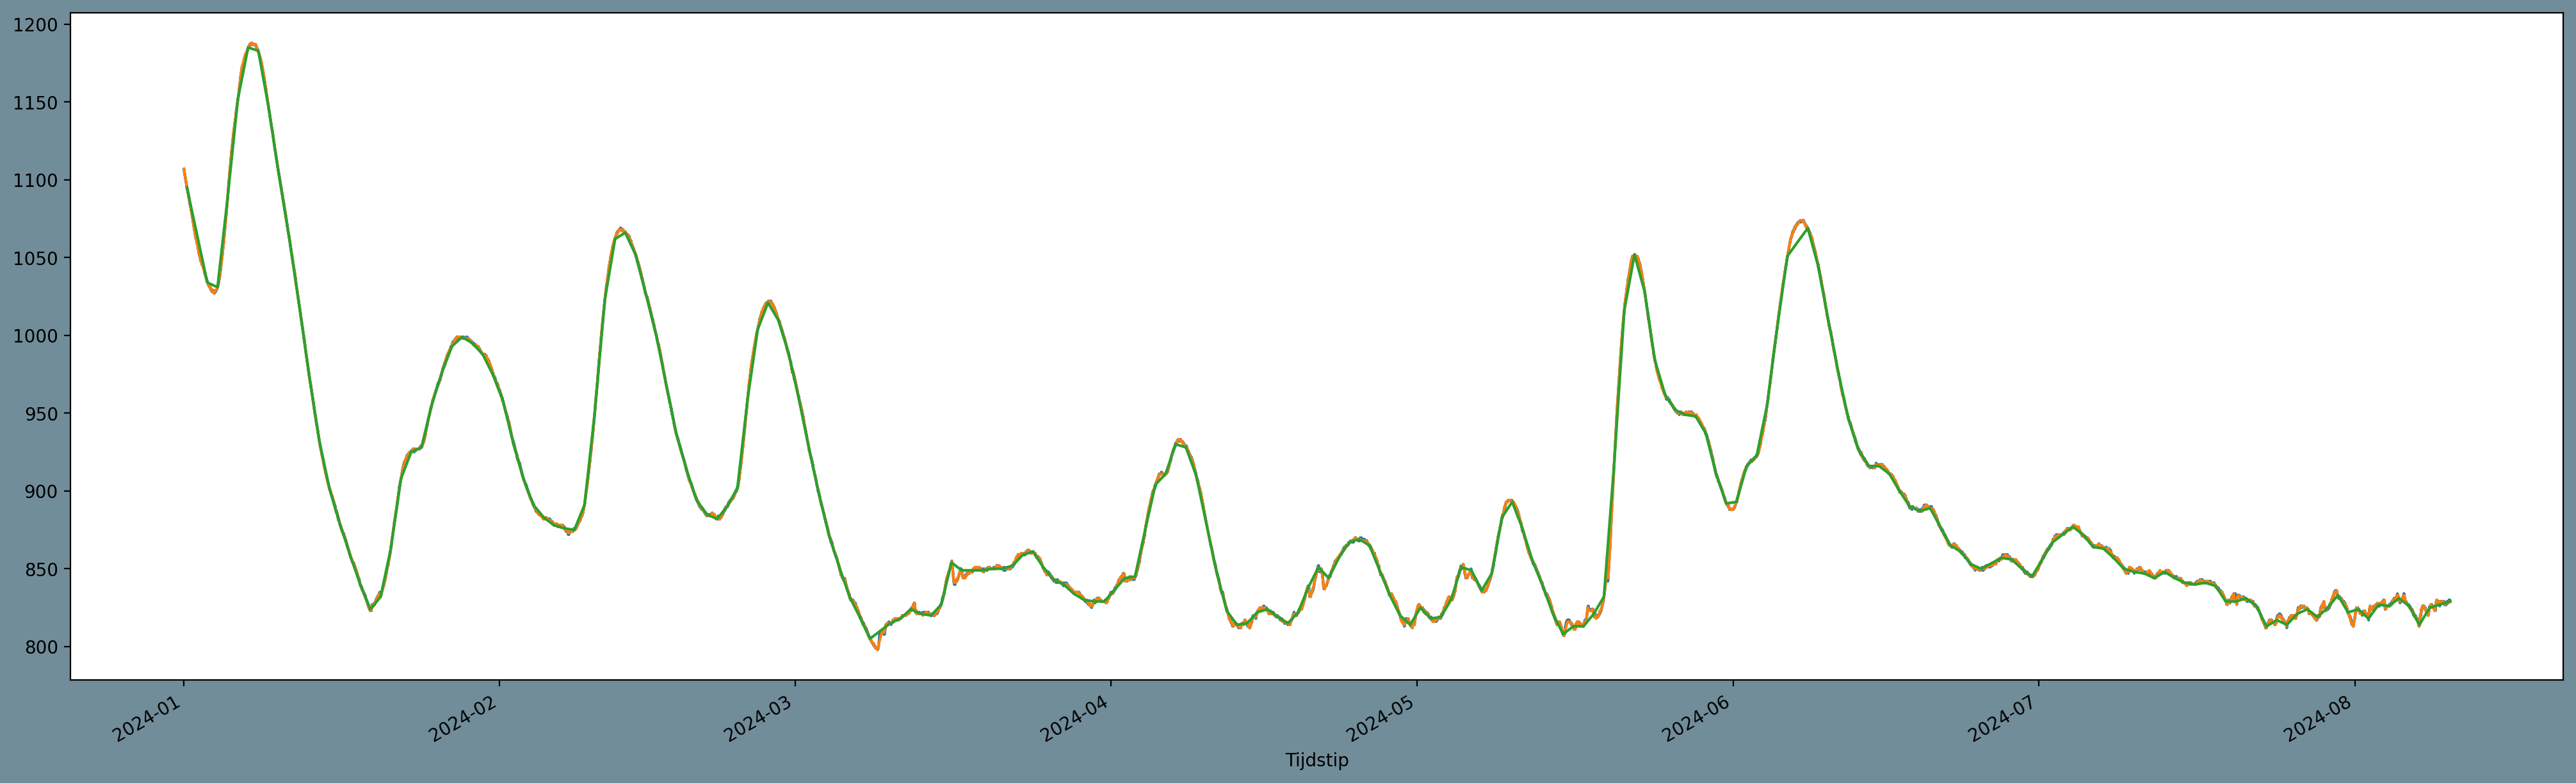

In [10]:
raw_series.plot()
hourly_series.plot()
daily_series.plot()

### Groupby filtering

The second method, which might be the most robust, is using a groupby.

With this method we get a equidistant time in the daily data and it's not missing any important peaks.

In [11]:
grp_daily = raw_series.groupby([raw_series.index.year, raw_series.index.month, raw_series.index.day]).median()
grp_daily.index = map(lambda x: datetime(*x), grp_daily.index.values)
grp_hourly = raw_series.groupby([raw_series.index.year, raw_series.index.month, raw_series.index.day, raw_series.index.hour]).median()
grp_hourly.index = map(lambda x: datetime(*x), grp_hourly.index.values)

In [12]:
pd.Series({
    'Hourly': np.diff(grp_hourly.index).astype(float).std(),
    'Daily': np.diff(grp_daily.index).astype(float).std()
})

Hourly    4.439189e+11
Daily     0.000000e+00
dtype: float64

<Axes: xlabel='Tijdstip'>

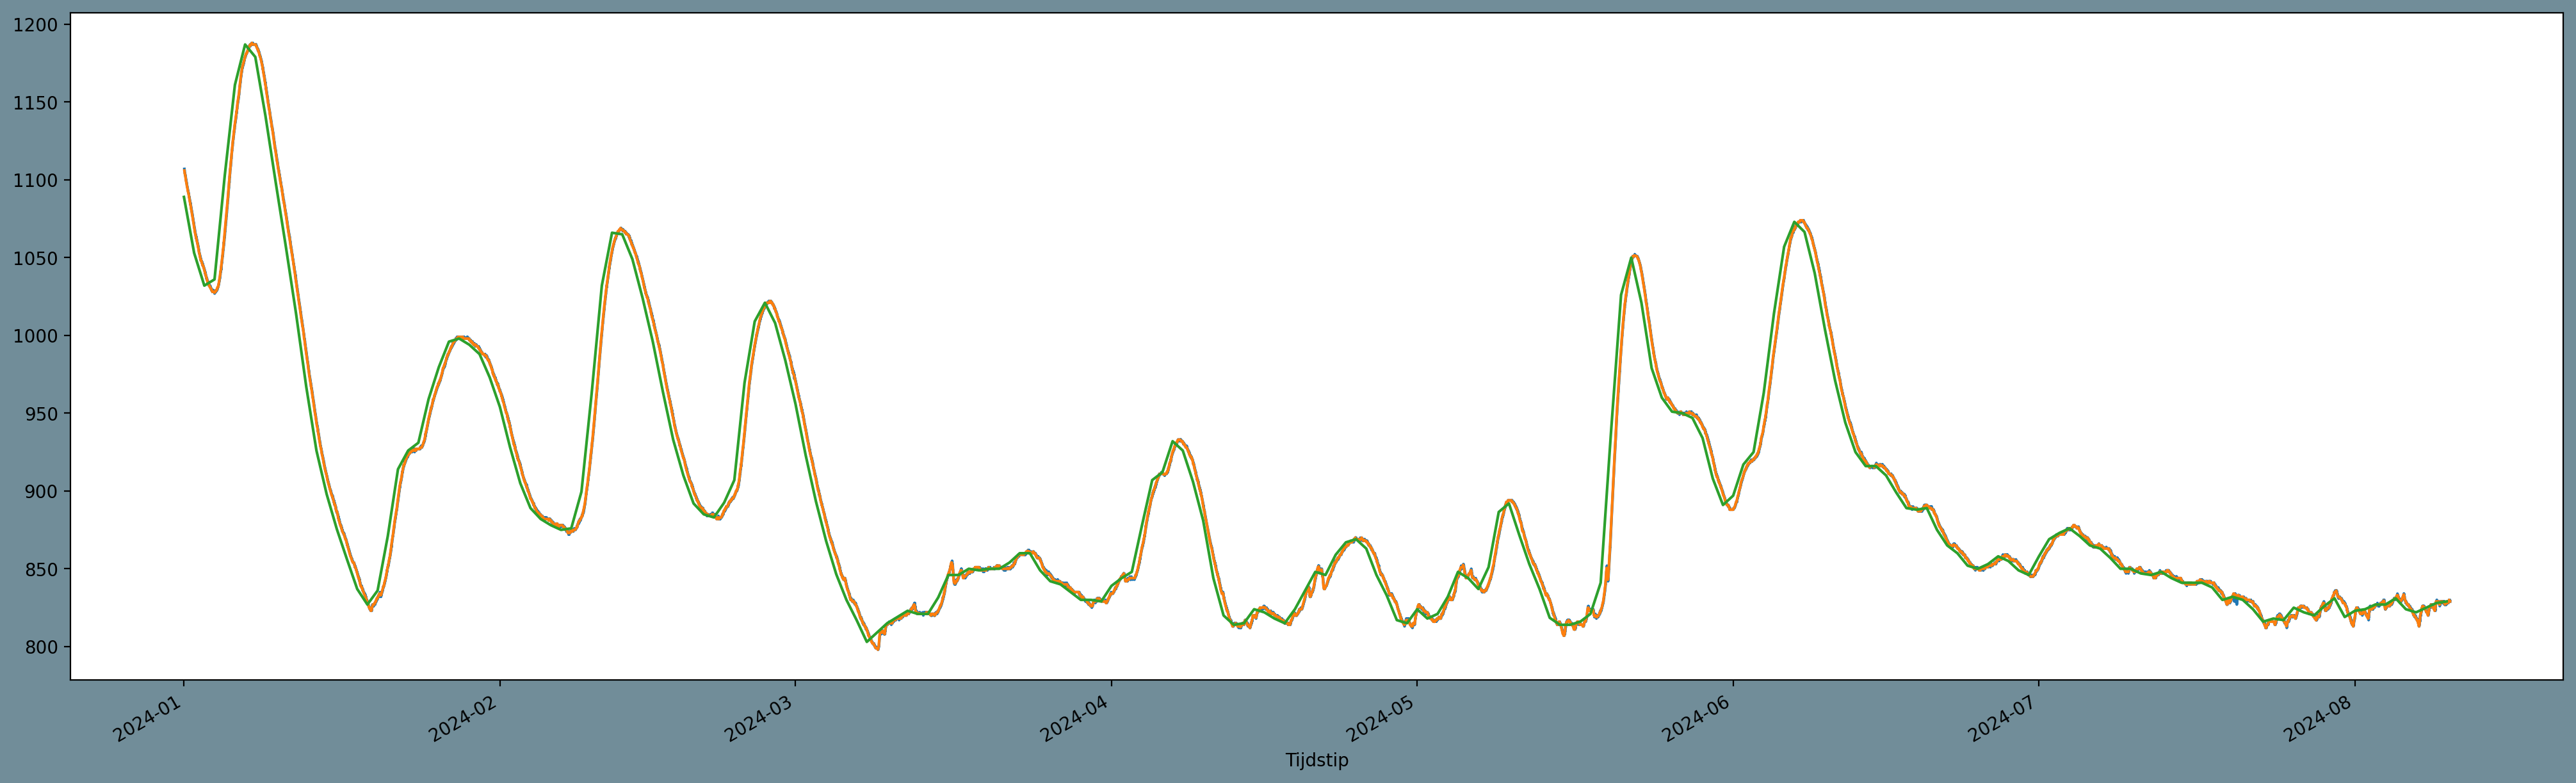

In [13]:
raw_series.plot()
grp_hourly.plot()
grp_daily.plot()

## Weather data

In [14]:
rename = {'temp': 'Temperature', 'tavg': 'Temperature', 'prcp': 'Precipitation'}
select = ['Temperature', 'Precipitation']
loc_arnhem = Point(51.9800, 5.9111)

we_daily = Daily(loc_arnhem, start, end).fetch().rename(rename, axis=1)[select]

In [15]:
np.diff(we_daily.index).astype(float).std()

np.float64(0.0)

<Axes: xlabel='time'>

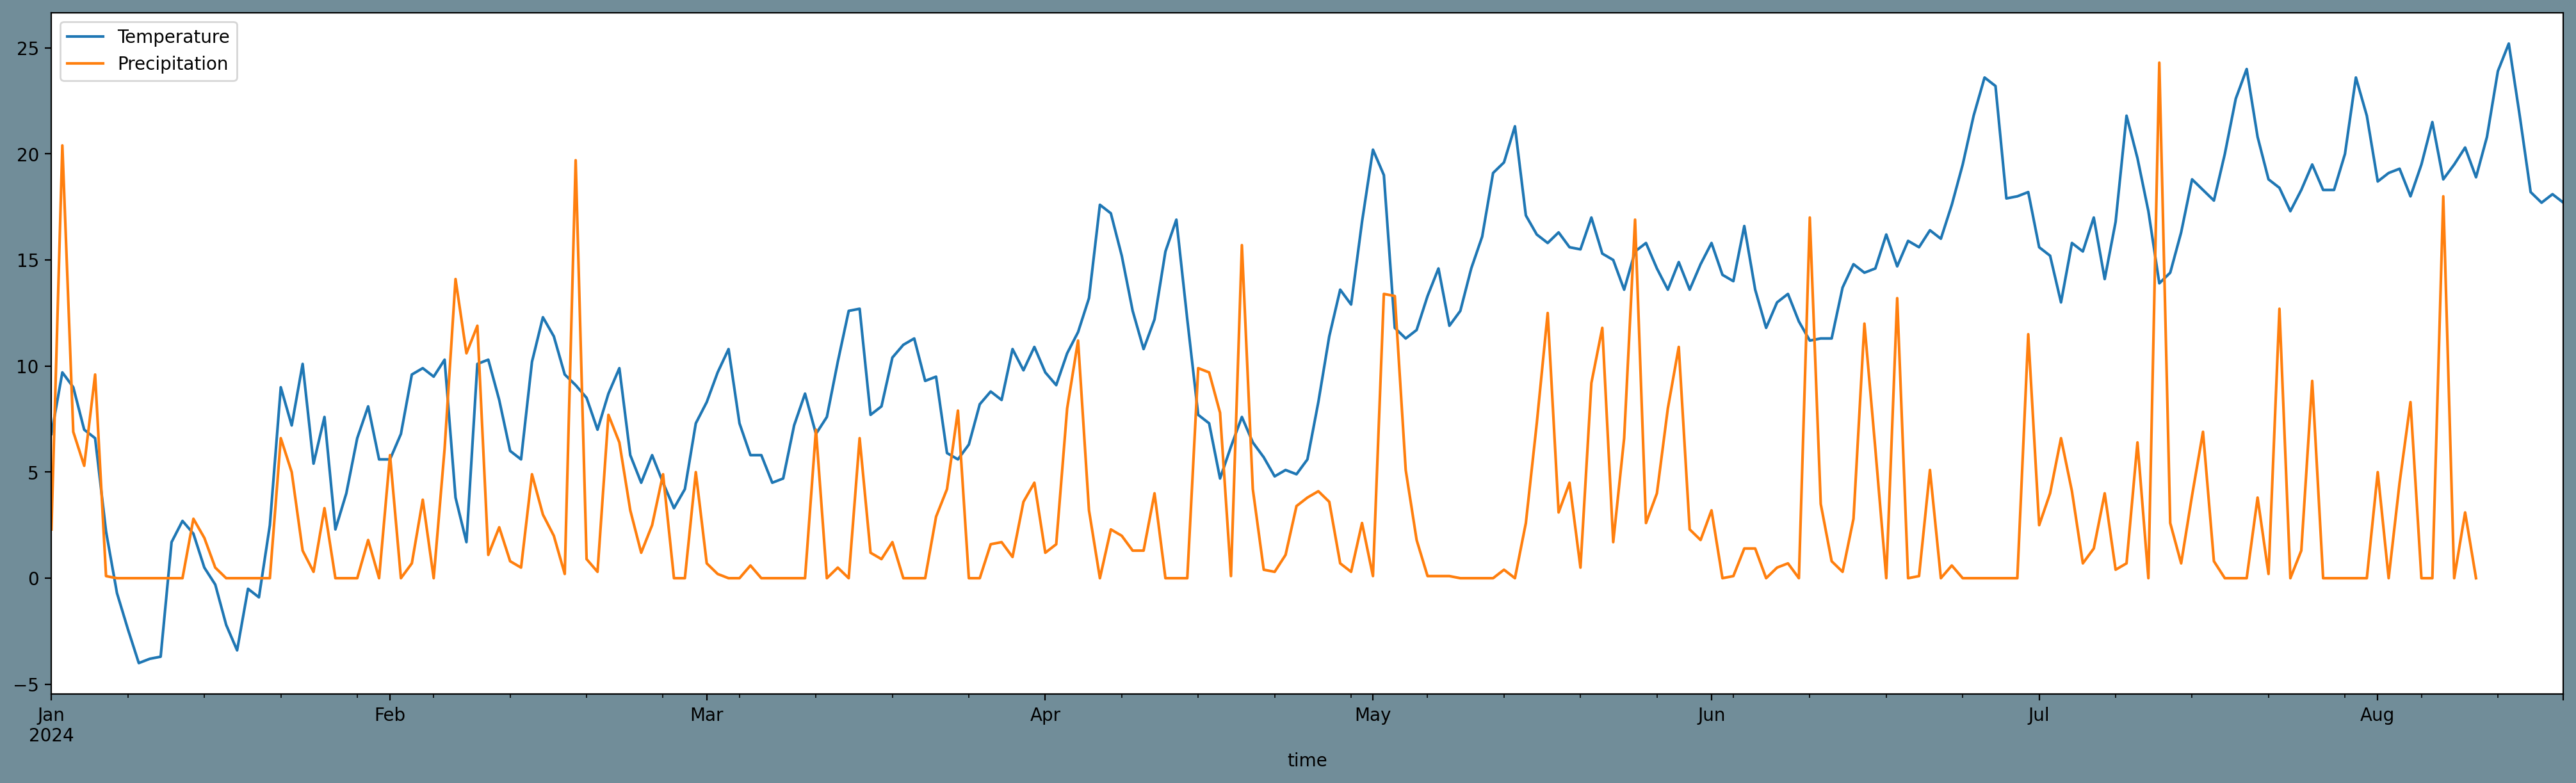

In [16]:
we_daily.plot()

# Combined data

When we combine this data, we already see some slight trends.
For example, as the temperature rises the water levels tends to be less high.
Which is in line with common knowledge about waterlevels on the rhine.

In [17]:
df = pd.concat([grp_daily, we_daily], axis=1).dropna()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

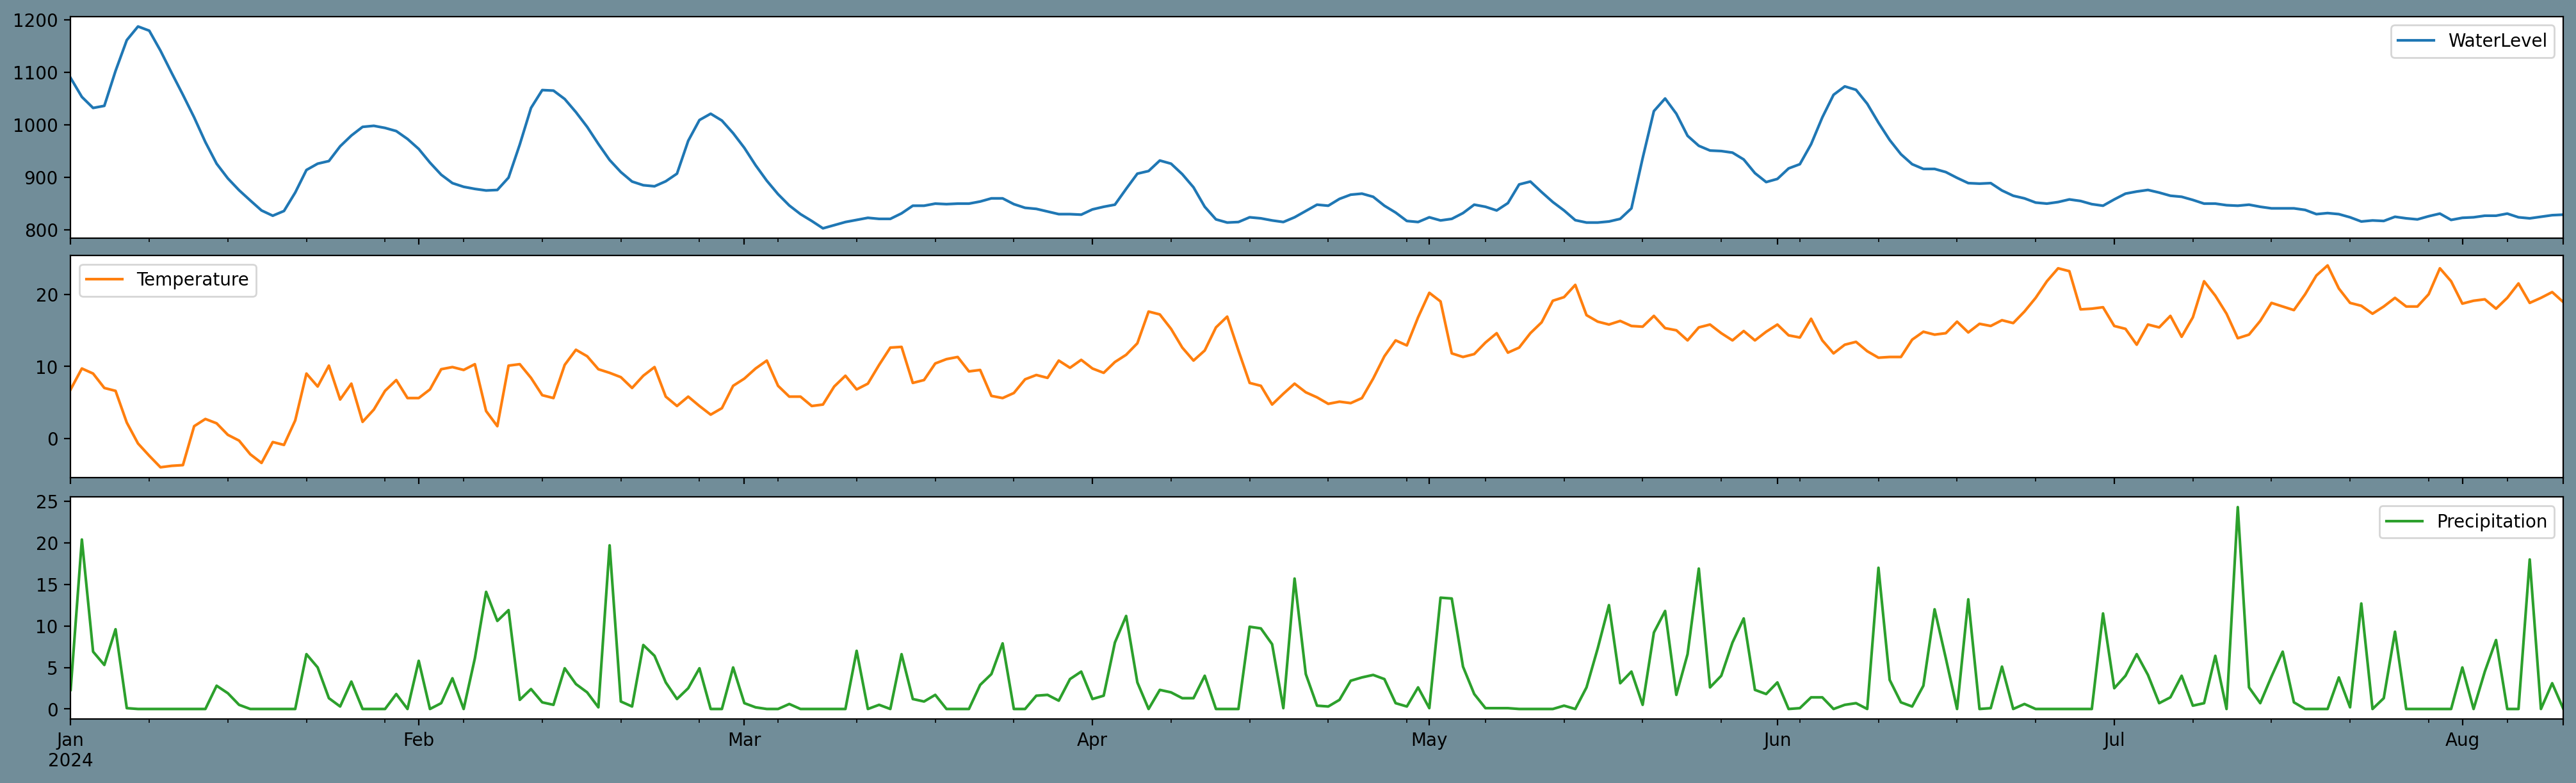

In [18]:
df.plot(subplots=True)

## Analysis

When we dive a little deeper we see that the waterlevel and precipitation is similary distributed.
This might indicate a similarity in behavior.

In [19]:
df.describe()

,WaterLevel,Temperature,Precipitation
count,223.000000,223.000000,223.000000
mean,894.677130,11.644843,3.118834
std,81.208156,6.059975,4.478648
min,803.000000,-4.000000,0.000000
25%,832.500000,7.300000,0.000000
50%,863.000000,11.800000,1.200000
75%,931.500000,16.200000,4.200000
max,1187.000000,24.000000,24.300000


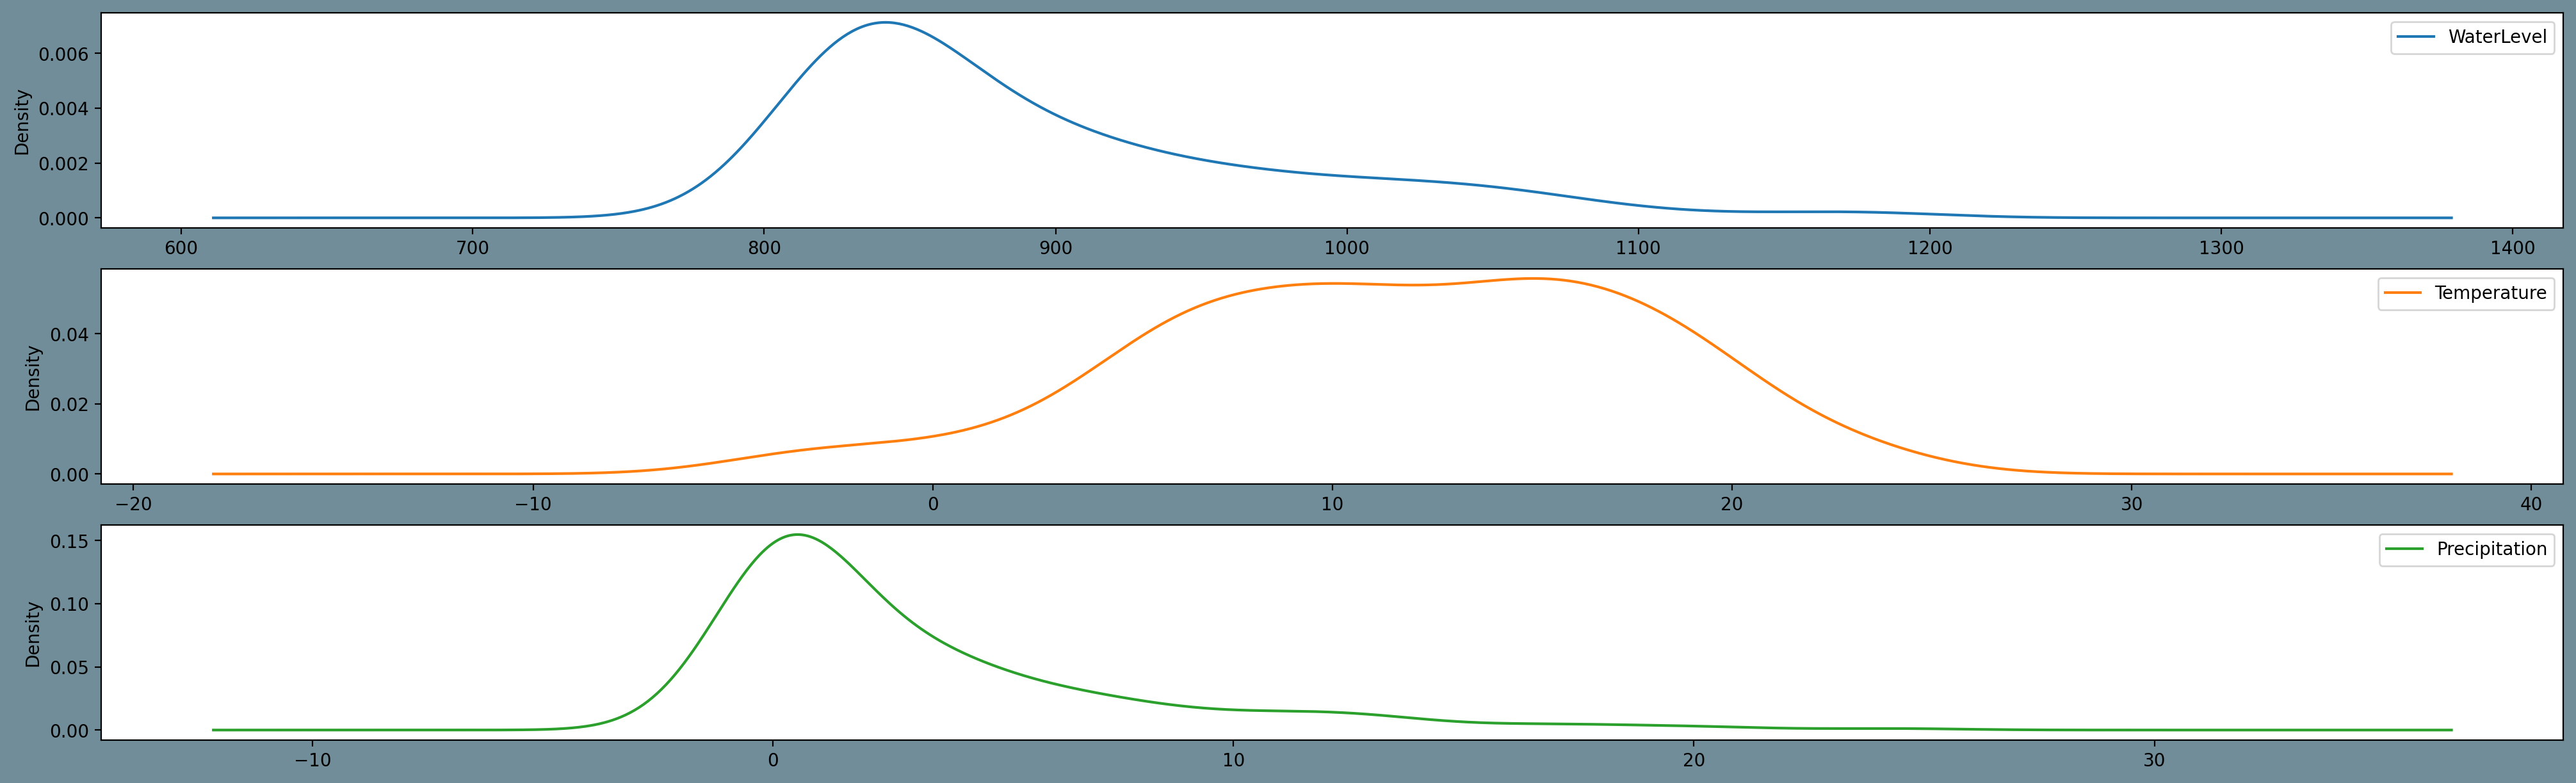

In [20]:
ax = df.plot.density(subplots=True, sharex=False)
# df.plot.hist(ax=ax,  subplots=True, sharex=False, density=True, histtype='step', bins=200)

## Correlation

We see that althought the correlation is very low the significance of it is quite high.
Indicating that rain has a very small effect on the waterlevels.
What might be intresting to explore is how much rainfall further upstream might influence the waterlevels.

In [21]:
correlation_significance(df)

WaterLevel           Temperature           Precipitation  \
              Correlation   P-Value Correlation   P-Value   Correlation   
WaterLevel            1.0       0.0   -0.411385       0.0      0.007857   
Temperature     -0.411385       0.0         1.0       0.0      0.051165   
Precipitation    0.007857  0.907117    0.051165  0.447095           1.0   

                         
                P-Value  
WaterLevel     0.907117  
Temperature    0.447095  
Precipitation       0.0

## Most probable maximum

If we then take a look at estimating the the most probable maximum we see that it is seems that weibull estimates the MPM quite well.
We can then use that fit to estimate the 100 year return water level. Which should be somewhere near 1331 cm, since that is highest waterlevel on record. Both overestimate this, but that makes sense since the dataset is very limited.

In [22]:
from scipy.stats import weibull_min, gumbel_r

wfit = weibull_min.fit(df['WaterLevel'])
gfit = gumbel_r.fit(df['WaterLevel'])

In [23]:
prob = 1/df.shape[0]
weibull_min.isf(prob, *wfit), gumbel_r.isf(prob, *gfit)

(np.float64(1213.4812071864412), np.float64(1145.5402340167473))

In [24]:
p_1y = 1/(100*365)
weibull_min.isf(p_1y, *wfit), gumbel_r.isf(p_1y, *gfit)

(np.float64(1526.6081528166637), np.float64(1414.8770528179655))

# Predicting

Finally we attempt to train some simple models to see how well we can predict waterlevels based on the the date, temperature and precipitation.
First we prepare the data such that date is split into its individual components and split it into features and target.
Subsequently, we train three types of models; K-nearest neighbors, Linear regression and Support vector machine.

- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [26]:
pred_df = df.copy()
pred_df.index.name = 'date'
pred_df.reset_index(inplace=True)
pred_df = pd.concat([
    pred_df['date'].astype(str).str.split('-', expand=True).rename({0: 'Year', 1: 'Month', 2: 'Day'}, axis=1),
    pred_df.drop('date', axis=1)
], axis=1).astype(float)

In [27]:
x = pred_df.copy()
y = x.pop('WaterLevel').values
x = x.values

## Training

Due to limited amount of data the results are not very good.
That was expected when we look at the correlation table.

However, the K-nearest neighbor models perform quite well compared to the others.
This might indicate that the data contains some non-linearities.
We might expect that the support vector machine would catch these.
But its likely due to lack of data that it doesn't.

In [34]:
cv_kwargs = dict(
    X=x,
    y=y,
    cv=KFold(3, shuffle=True, random_state=0),
    scoring=make_scorer(r2_score),
    return_estimator=True,
    return_train_score=True,
)

In [35]:
knr_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('Regressor', KNeighborsRegressor()),
])
cv = cross_validate(knr_pipe, **cv_kwargs)
pd.DataFrame(cv)

,fit_time,score_time,estimator,test_score,train_score
0,0.000907,0.001332,"(StandardScaler(), KNeighborsRegressor())",0.506272,0.661285
1,0.002147,0.002406,"(StandardScaler(), KNeighborsRegressor())",0.521105,0.673386
2,0.000977,0.001013,"(StandardScaler(), KNeighborsRegressor())",0.424305,0.772949


In [36]:
lin_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('Regressor', LinearRegression()),
])
cv = cross_validate(lin_pipe, **cv_kwargs)
pd.DataFrame(cv)

,fit_time,score_time,estimator,test_score,train_score
0,0.002251,0.000000,"(StandardScaler(), LinearRegression())",0.138405,0.255099
1,0.000972,0.000942,"(StandardScaler(), LinearRegression())",0.243282,0.193278
2,0.000000,0.001500,"(StandardScaler(), LinearRegression())",0.128943,0.228141


In [37]:
svr_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('Regressor', SVR(kernel='poly')),
])
cv = cross_validate(svr_pipe, **cv_kwargs)
pd.DataFrame(cv)

,fit_time,score_time,estimator,test_score,train_score
0,0.002011,0.001000,"(StandardScaler(), SVR(kernel='poly'))",0.089181,0.158294
1,0.001431,0.001019,"(StandardScaler(), SVR(kernel='poly'))",0.034557,0.099125
2,0.002652,0.000967,"(StandardScaler(), SVR(kernel='poly'))",0.218088,0.127590


# References:

1. https://meteostat.net/en/station/06275?t=2000-01-01/2000-01-31
1. https://www.gelderlander.nl/arnhem/hoogwaterpiek-13-meter~ac9b2371/#:~:text=Het%20is%20voor%20het%20eerst,boven%20NAP%20de%20hoogste%20waterstand.